In [1]:
# All Imports
import cv2
import math
import random
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
# All defined functions
import requests
from PIL import Image

# Function to load the online image.
def load_image(name, no_alpha=True):
    url = f'https://cloud.dfki.de/owncloud/index.php/s/THLirfoB6SYTetn/download?path=&files={name}'
    image = np.asarray(Image.open(requests.get(url, stream=True).raw))
    if no_alpha and len(image) > 2 and image.shape[2] == 4:
        image = image[:,:,:3]
    return image[:,:,::-1].copy()

# Function for resizing the image
def resize(image, scale):
    return cv2.resize(image, (int(image.shape[1]*scale), int(image.shape[0]*scale)))

# Function to print images size-by-size
def show(*images, titles=None, figsize=None):
    ROWS, COLS = 1, len(images)
    if figsize is not None:
        plt.figure(figsize=(18,6))
    for i, img in enumerate(images):
        plt.subplot(ROWS, COLS, i+1)
        if titles is not None:
            plt.title(titles[i])
        if len(img.shape) == 3:
            plt.imshow(img[:,:,::-1])
        else:
            plt.imshow(img)
    plt.show()

# Function to convert the image into grayscale    
def gray(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Finding the point at which the template matches
def argmax_2d(image):
    return np.unravel_index(np.argmax(image), image.shape)

# Function for squaring each element of a matrix 
def elementwise_square(matrix):
    new_matrix=np.zeros_like(matrix)                        # Creating a output matrix of the same size as the input matrix but with 0 value
    # Loop for performing square of each element in the matrix
    for i in range(matrix.shape[0]):
        for j in range (matrix.shape[1]):
            new_matrix[i,j]=matrix[i,j]**2

    return new_matrix

# Function for summing all the elements of a matrix
def sum_of_elements_matrix(buffer):
    buffer_value=0                                          # Initialising the buffer value
    # Loop for adding all the values in a the input matrix
    for i in range (buffer.shape[0]):
        for j in range (buffer.shape[1]):
            buffer_value=buffer_value+buffer[i,j]          

    return buffer_value

# Function for performing multiplying each element of 2 matrices
def elementwise_multiplication(image_patch,kernel,image_patch_mean,kernel_mean):
    buffer=np.zeros_like(image_patch)                       # Creating a output matrix of the same size as the input matrix but with 0 value
    # Loop to perform the elementwise matrix multiplication
    for i in range (image_patch.shape[0]):
        for j in range (image_patch.shape[1]):
            buffer[i,j]=(image_patch[i,j]-image_patch_mean)*(kernel[i,j]-kernel_mean)
            
    return sum_of_elements_matrix(buffer) 

<p style="page-break-after:always;"></p>

# Template Matching: Cross-Correlation
---

<div style="background-color: #042c58; color: #ffffff; width: 100%; padding: 0.3em; font-size:1.1em; font-weight: bold;">Cross-Correlation</div>
<div style="background-color: #d7e9fd; width: 100%; padding-top: 0.5em; padding-bottom: 0.3em">
    
<center>Given a template $H$ and an image $F$, the cross-correlation is defined as:</center>


$$ G(u,v) = \sum_{i} \sum_{j} H(i,j) F(u+i, v+j)$$

</div>

A grayscale image $I$ and a grayscale template $H$ are given. Computing the cross-corelation between the two.

10 253


100%|██████████| 50/50 [00:06<00:00,  7.50it/s]


Point at which the template matches (32, 45)


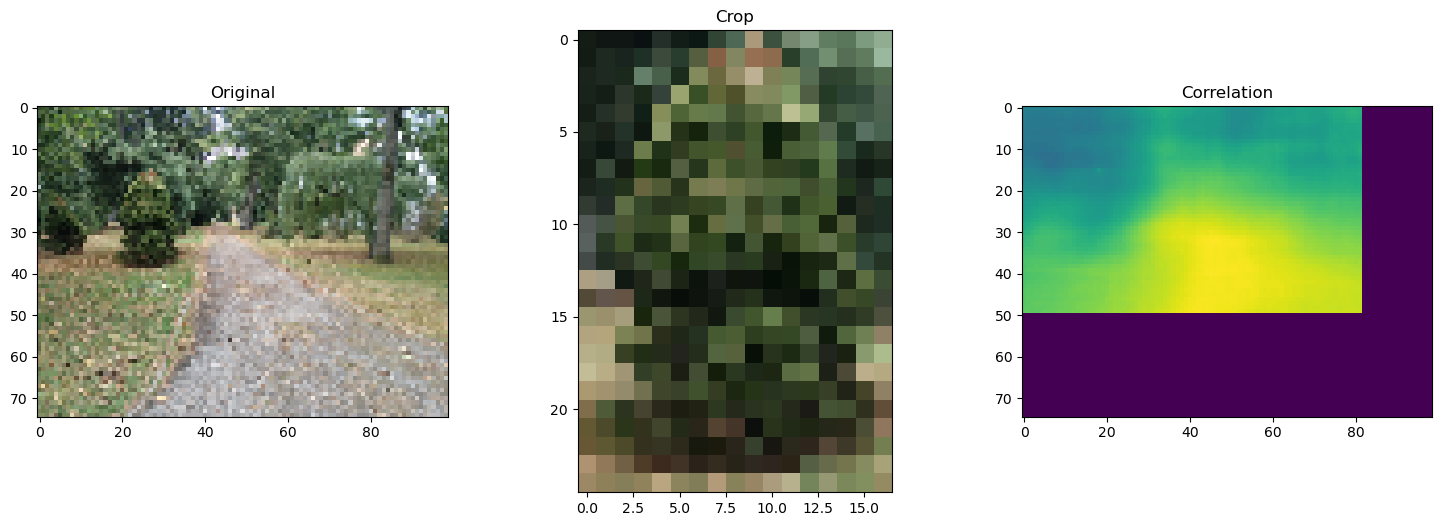

In [3]:
# Cross-Corelation
I = resize(load_image("park.png"), 0.15)                        # Resizing the image to increase the computational speed
H = I[15:40, 18:35]                                             # Considering a random template

new_img=np.zeros_like(I)

def cross_correlation(I, H):
    # TODO
    print(I.min(),I.max())
    I=I.astype(np.float32)                                      # Converting the image to float
    H=H.astype(np.float32)                                      # Converting the kernel to float
    G=np.zeros_like(I)                                          # Creating an output matrix with all values as 0                                            
    
    # Looping to get the output image
    for i in tqdm(range (I.shape[0]-H.shape[0])):
        for j in range (I.shape[1]-H.shape[1]):
            image_patch=I[i:i+H.shape[0],j:j+H.shape[1]]        # Extracting image patches of size and shape of the kernel 'H'
            # Calling the function elementwise multiplication to perform multiplication between every element between the image patch and kernel
            G[i,j]=elementwise_multiplication(image_patch,H,0,0)    
               
    return G

G = cross_correlation(gray(I), gray(H))
print("Point at which the template matches",argmax_2d(G))
show(
    I, H, G,
    titles=["Original", "Crop", "Correlation"],
    figsize=(18,6)  # Make a wide figure.
)

The result of the cross corelation does not locate the crop yet.
To achieve this, we actually have to compute the normalized cross_corelation.

<p style="page-break-after:always;"></p>

# Template Matching: Normalized Cross-Correlation
---



Implementing Normalized cross-correlation

100%|██████████| 50/50 [00:08<00:00,  5.64it/s]


Point at which the template matches (15, 18)


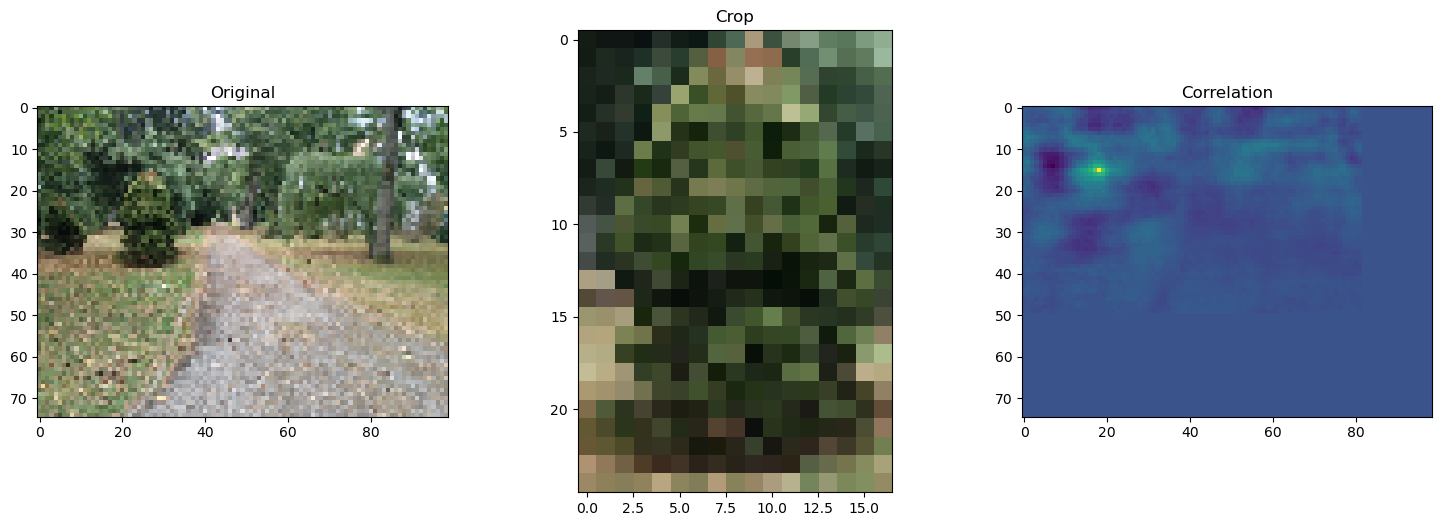

In [4]:
# Normalized Cross-Corelation
I = resize(load_image("park.png"),scale=0.15)                                                       # Resizing the image to increase the computational speed
H = I[15:40, 18:35]                                                                                 # Considering a random template

def normalized_cross_correlation(I, H):
    # TODO
    I=I.astype(np.float32)                                                                          # Converting the image to float            
    H=H.astype(np.float32)                                                                          # Converting the kernel to float
    G=np.zeros_like(I)                                                                              # Creating output matrix of same size and shape as Input image matrix with 0
    H_mean=np.mean(H)
    
    # Looping to apply the Normalized Cross Correlation
    for i in tqdm(range (I.shape[0]-H.shape[0])):                                               
        for j in range (I.shape[1]-H.shape[1]):
            image_patch=I[i:i+H.shape[0],j:j+H.shape[1]]                                            # Extracting image patches of same size as kernel
            image_patch_mean=np.mean(image_patch)
            # Calling the function elementwise multiplication to perform multiplication between every element between the image patch and kernel
            buffer_numerator=elementwise_multiplication(image_patch,H,image_patch_mean,H_mean)   
            # Calling the functions of elementwise square which squares every element of the matrix and calling the function of sum of element matrix which sums up all the elements in a matrix                           
            buffer_denominator=math.sqrt(sum_of_elements_matrix(elementwise_square(H))*(sum_of_elements_matrix(elementwise_square(image_patch))))
            G[i,j]=buffer_numerator/buffer_denominator                                              # Dividing numerator and denominator

    return G

G = normalized_cross_correlation(gray(I), gray(H))
print("Point at which the template matches",argmax_2d(G))
show(
    I, H, G,
    titles=["Original", "Crop", "Correlation"],
    figsize=(18,6)  # Make a wide figure.
)

The brightest point represents the matched template.